In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# collocation
import sys
import os
import pickle
def append_path(path):
    if path not in sys.path:
        sys.path.append(path)
        
append_path(os.path.abspath(os.path.join('..', '00_utils')))
append_path(os.path.abspath(os.path.join('..', '00_utils_training')))
append_path(os.path.abspath(os.path.join('..', '00_models')))

import preprocess # helper preprocessing class

# pyomo
import importlib
import nn_pytorch
import torch

import analyse_results
reload_module = analyse_results.reload_module

prepare_custom_weights = reload_module('utils_pytorch', 'prepare_custom_weights')

In [27]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

def save_results(results, description):
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    path = f'results/{description}_{formatted_time}_full.pkl'
    with open(path, 'wb') as file:
        pickle.dump(results, file)
    print(f"Results saved to {path}")

def calculate_averages(data):
    total_mse_train = 0
    total_mse_test = 0
    total_time_elapsed = 0

    # Loop through each entry to accumulate sums
    for entry in data.values():
        total_mse_train += entry['mse_train']
        total_mse_test += entry['mse_test']
        total_time_elapsed += entry['time_elapsed'][0]  # assuming time_elapsed is always a list with one element

    # Calculate averages
    num_entries = len(data)
    averages = {
        'average_mse_train': total_mse_train / num_entries,
        'average_mse_test': total_mse_test / num_entries,
        'average_time_elapsed': total_time_elapsed / num_entries
    }

    return averages

# , 'temperature': 'var1'
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

rng = random.PRNGKey(42)

In [22]:
path = '../00_trained_wb/trained_wb_2024-09-02_14-40-45.pkl'
# import trained weights
with open(path, 'rb') as file:
    trained_wb = pickle.load(file)
    
trained_wb = prepare_custom_weights(trained_wb)

path = '../00_trained_wb/trained_wb_2024-09-03_11-02-48.pkl'
# import trained weights
with open(path, 'rb') as file:
    trained_wb_short = pickle.load(file)
    
trained_wb_short = prepare_custom_weights(trained_wb_short)

In [24]:
from datetime import datetime, timedelta

freq = 35
number = 10 

# prepare data ranges
START_DATE = '2015-01-10'
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
date_sequences = [start_date + timedelta(days=i*freq) for i in range(number)]
date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
print(date_sequences_str)

['2015-01-10', '2015-02-14', '2015-03-21', '2015-04-25', '2015-05-30', '2015-07-04', '2015-08-08', '2015-09-12', '2015-10-17', '2015-11-21']


Epoch 0, Training Loss: 1.9261040687561035
Epoch 100, Training Loss: 0.14910247921943665
Epoch 200, Training Loss: 0.07346261292695999
Epoch 300, Training Loss: 0.0482565276324749
Epoch 400, Training Loss: 0.038112789392471313
Epoch 500, Training Loss: 0.022279787808656693
Epoch 600, Training Loss: 0.015347527340054512
Epoch 700, Training Loss: 0.012255213223397732
Epoch 800, Training Loss: 0.009007004089653492
Epoch 900, Training Loss: 0.03138734772801399
Epoch 0, Training Loss: 1.5925393104553223
Epoch 100, Training Loss: 0.3040795624256134
Epoch 200, Training Loss: 0.1087433397769928
Epoch 300, Training Loss: 0.03695639967918396
Epoch 400, Training Loss: 0.02933475933969021
Epoch 500, Training Loss: 0.01756662130355835
Epoch 600, Training Loss: 0.014308910816907883
Epoch 700, Training Loss: 0.011778529733419418
Epoch 800, Training Loss: 0.011826401576399803
Epoch 900, Training Loss: 0.01167367771267891
Epoch 0, Training Loss: 1.758975863456726
Epoch 100, Training Loss: 0.20091854035

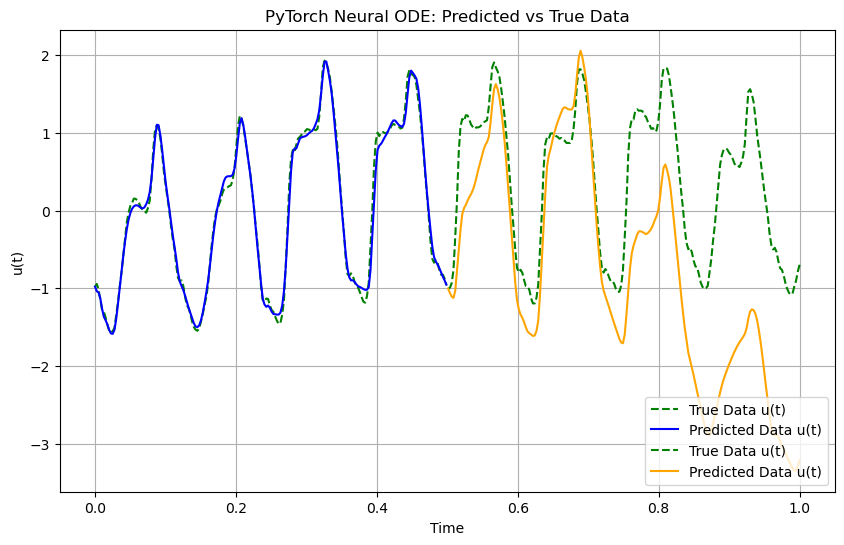

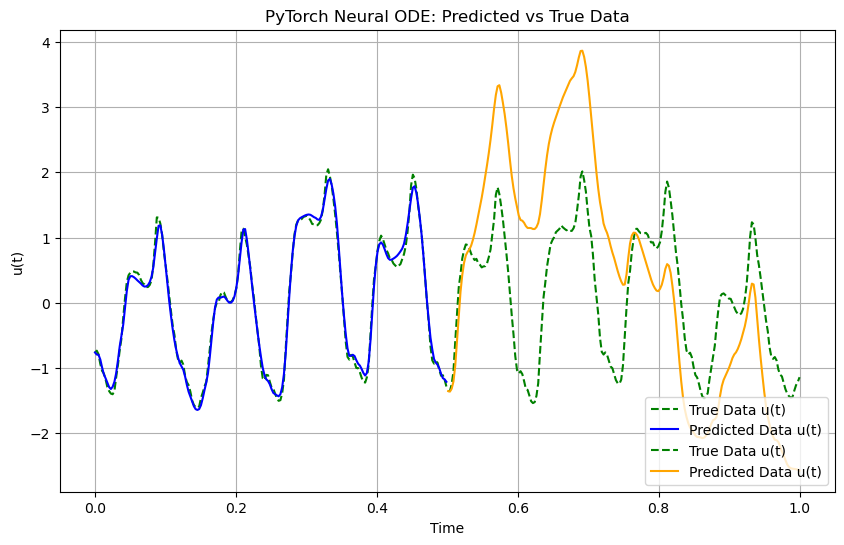

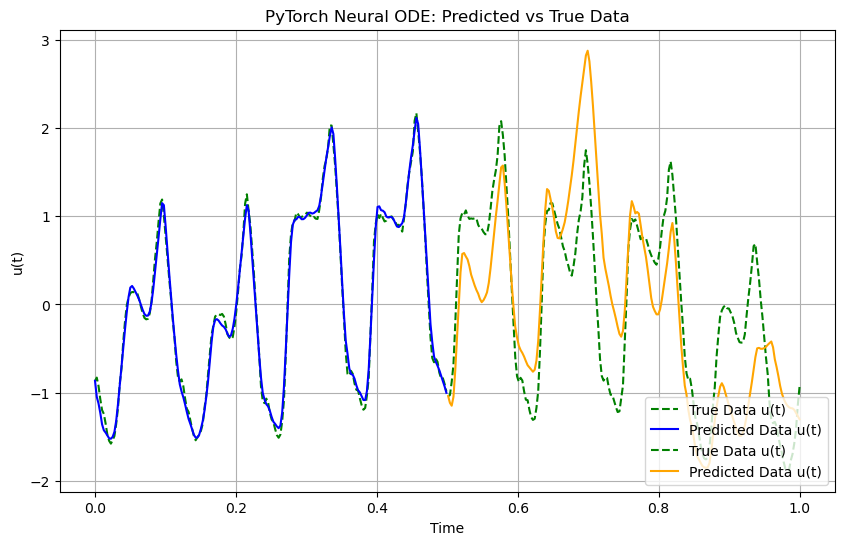

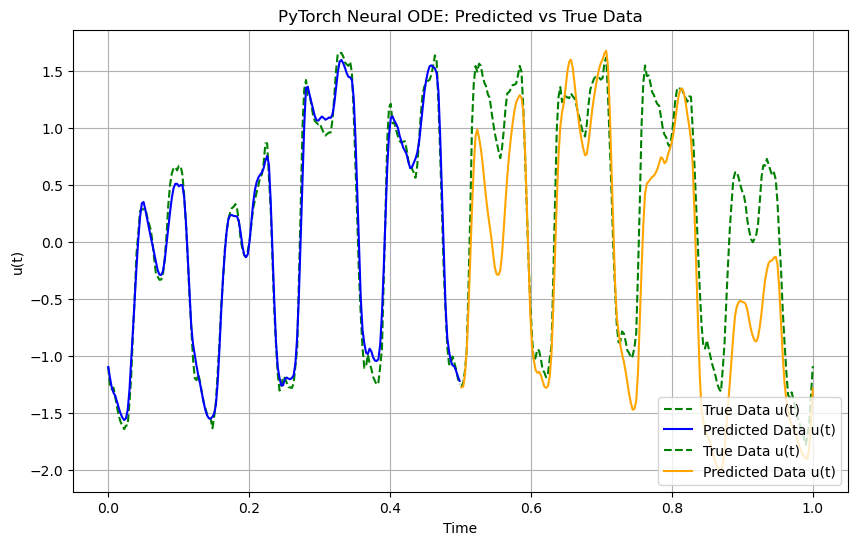

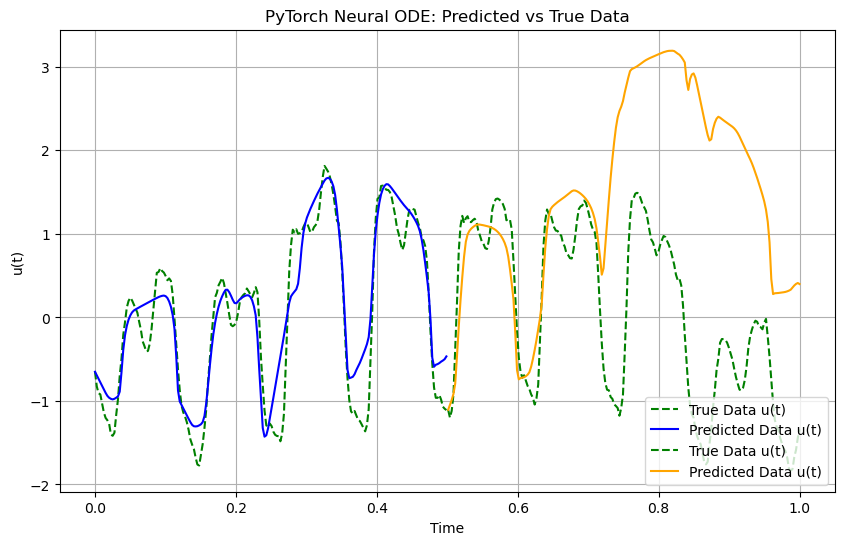

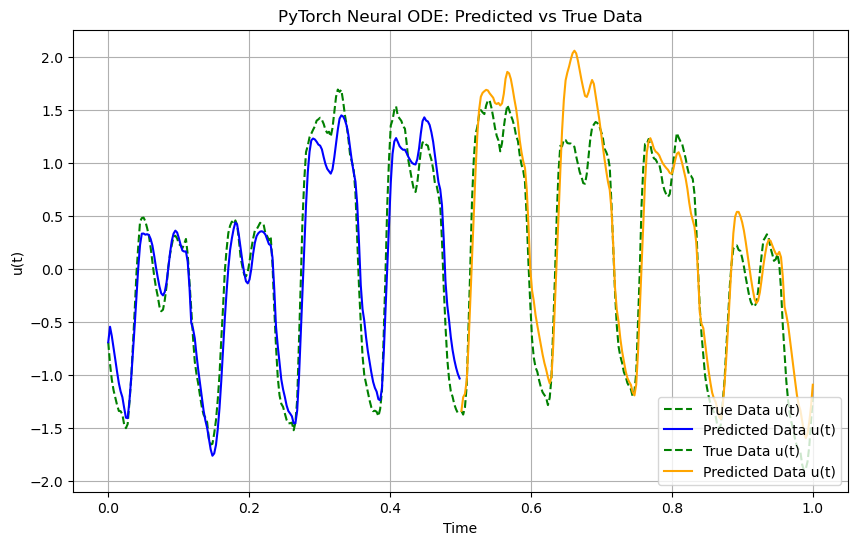

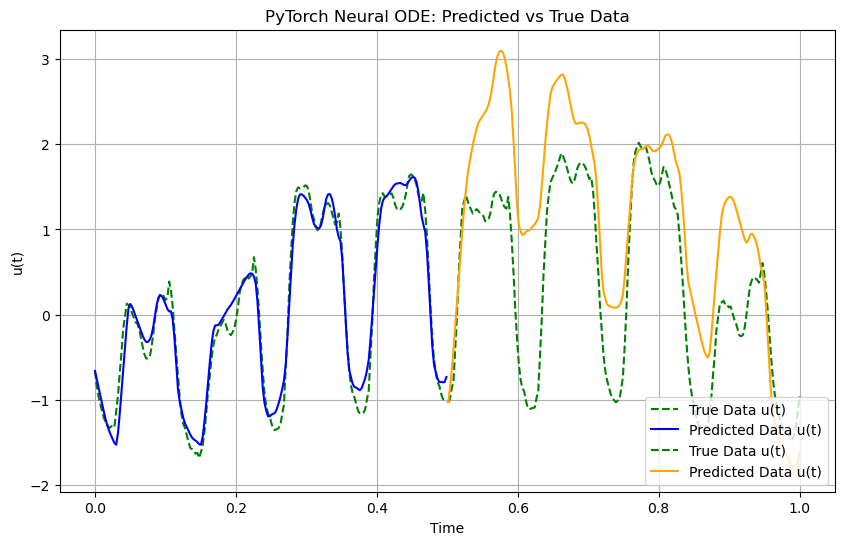

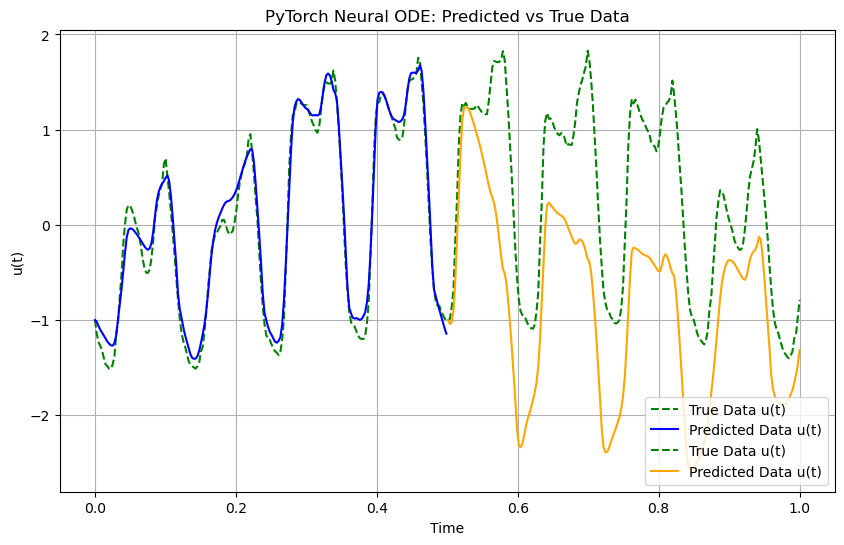

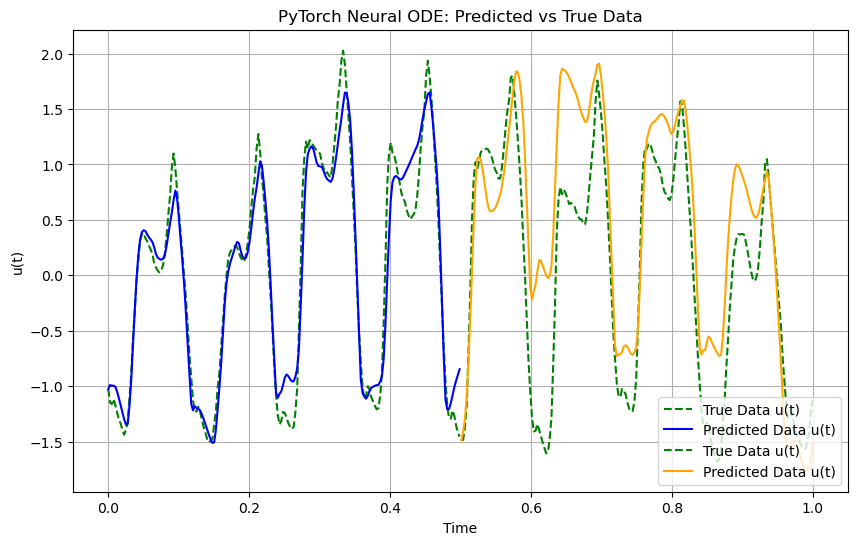

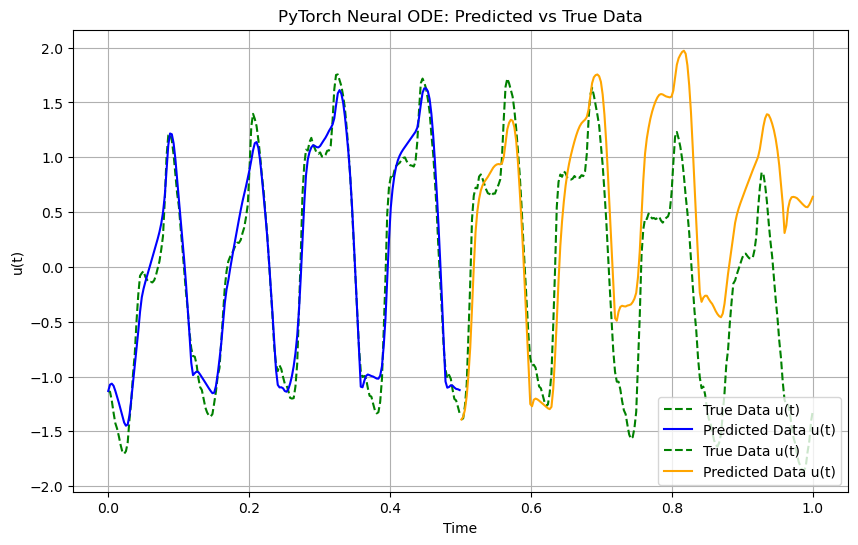

In [42]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [7, 32, 1]
learning_rate = 1e-1
weight_decay = 1e-5
experiment_results = {}

START_DATE = date_sequences_str[0]
learning_rates = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
logging = False
plotting = True

for START_DATE in date_sequences_str:

    data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 1, 
                                feature_encoding = encoding, split = 200,
                                smooth = False, num_nodes_mult = 1,
                                prev_hour = True, prev_week = True, prev_year = False)
    
    data_subsample = data_loader.load_data()
    df_train, df_test = data_loader.preprocess_data(data_subsample)
    
    ys = df_train['y']
    ts = df_train['t']
    Xs = df_train.drop(columns=['y', 't'])
    ys_test = df_test['y']
    ts_test = df_test['t']
    Xs_test = df_test.drop(columns=['y', 't'])
    Xs = np.concatenate([Xs, Xs_test])
    t_all = np.concatenate([ts, ts_test])

    y0 = torch.tensor(np.array([ys[0]]), dtype=torch.float32)
    ys = torch.tensor(np.atleast_2d(ys).T, dtype=torch.float32)
    ts = torch.tensor(np.array(ts), dtype=torch.float32)
    Xs = np.atleast_2d(Xs) # extra inputs
    
    y0_test = torch.tensor(np.array([ys_test[0]]), dtype=torch.float32)
    ys_test = torch.tensor(np.atleast_2d(ys_test).T, dtype=torch.float32)
    ts_test = torch.tensor(np.array(ts_test), dtype=torch.float32)

    ode_model = NeuralODE(layer_widths, learning_rate, weight_decay = weight_decay, time_invariant = True) # custom_weights = trained_wb

    if logging:
        log = {
                't': ts,
                'y': ys,
                'y_init': y0,
                'extra_args': None, # extra inputs are initializes in the trianing
                'epoch_recording_step' : 5,
                't_test': ts_test,
                'y_test': ys_test,
                'y_init_test': y0_test,
                'extra_args_test': None
        }
    else:
        log = False
    
    times_elapsed = []
    pre_train = False
    for k in [len(ts)]: # int(len(ts)*0.2),
        start_time = time.time()
        # pass in log true to obrain the training losses
        if pre_train:
            ode_model.train_model(ts[:k], ys[:k], y0, num_epochs = 400, rtol=1e-3, atol=1e-6, extra_inputs = (t_all, Xs))
            pre_train = False
            times_elapsed.append(time.time() - start_time)
            start_time = time.time()
        else:
            ode_model.train_model(ts[:k], ys[:k], y0, num_epochs = 1000, rtol=1e-3, atol=1e-6, extra_inputs = (t_all, Xs), log = log)
            times_elapsed.append(time.time() - start_time)
    
    y_pred = ode_model.predict(ts, y0, extra_inputs = Xs)
    y_pred_test = ode_model.predict(ts_test, y0_test, extra_inputs = Xs_test)
    
    param = START_DATE
    experiment_results[param] = {}
    experiment_results[param]['mse_train'] = np.mean(np.square(y_pred.detach().numpy().flatten() - ys.detach().numpy().flatten()))
    experiment_results[param]['mse_test'] = np.mean(np.square(y_pred_test.detach().numpy().flatten() - ys_test.detach().numpy().flatten()))
    experiment_results[param]['time_elapsed'] = times_elapsed
    
    if logging:
        experiment_results[param]['training_losses'] = ode_model.losses
        
    if plotting:
        y_test_pred = y_pred_test.detach().numpy().flatten()
        plt.figure(figsize=(10, 6))

        plt.plot(ts, ys, 'g--', label='True Data u(t)')  
        plt.plot(ts, y_pred, 'b', label='Predicted Data u(t)') 
        plt.plot(ts_test, ys_test, 'g--', label='True Data u(t)') 
        plt.plot(ts_test, y_test_pred, 'orange', label='Predicted Data u(t)') 

        plt.xlabel('Time')
        plt.ylabel('u(t)')
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.title('PyTorch Neural ODE: Predicted vs True Data')
        plt.savefig(f'../00_plots/pytorch/pytorch_train_{START_DATE}.png')

In [43]:
calculate_averages(experiment_results)

{'average_mse_train': 0.03573998576030135,
 'average_mse_test': 1.310081858187914,
 'average_time_elapsed': 121.14293308258057}

In [41]:
calculate_averages(experiment_results)

{'average_mse_train': 0.035260852938517925,
 'average_mse_test': 1.0334784552454948,
 'average_time_elapsed': 109.41575996875763}

In [45]:
1e-4

0.0001

In [44]:
experiment_results

{'2015-01-10': {'mse_train': 0.007925811,
  'mse_test': 2.232096,
  'time_elapsed': [102.91920518875122]},
 '2015-02-14': {'mse_train': 0.00725234,
  'mse_test': 2.0879757,
  'time_elapsed': [101.77969884872437]},
 '2015-03-21': {'mse_train': 0.0060348557,
  'mse_test': 0.54709363,
  'time_elapsed': [115.69524097442627]},
 '2015-04-25': {'mse_train': 0.011967216,
  'mse_test': 0.3756979,
  'time_elapsed': [120.47938299179077]},
 '2015-05-30': {'mse_train': 0.12579803,
  'mse_test': 3.9289427,
  'time_elapsed': [120.1329460144043]},
 '2015-07-04': {'mse_train': 0.06301135,
  'mse_test': 0.1171046,
  'time_elapsed': [175.7117781639099]},
 '2015-08-08': {'mse_train': 0.031321198,
  'mse_test': 0.9635701,
  'time_elapsed': [113.14871501922607]},
 '2015-09-12': {'mse_train': 0.01949224,
  'mse_test': 1.5142266,
  'time_elapsed': [111.2119529247284]},
 '2015-10-17': {'mse_train': 0.05290054,
  'mse_test': 0.43635136,
  'time_elapsed': [137.15232491493225]},
 '2015-11-21': {'mse_train': 0.031

In [30]:
calculate_averages(experiment_results)

{'average_mse_train': 0.3915593683719635,
 'average_mse_test': 1.0756867170333861,
 'average_time_elapsed': 7.496629977226258}

In [39]:
save_results(experiment_results, 'short_training_pytorch')

Results saved to results/short_training_pytorch_2024-09-08_13-38-20_full.pkl


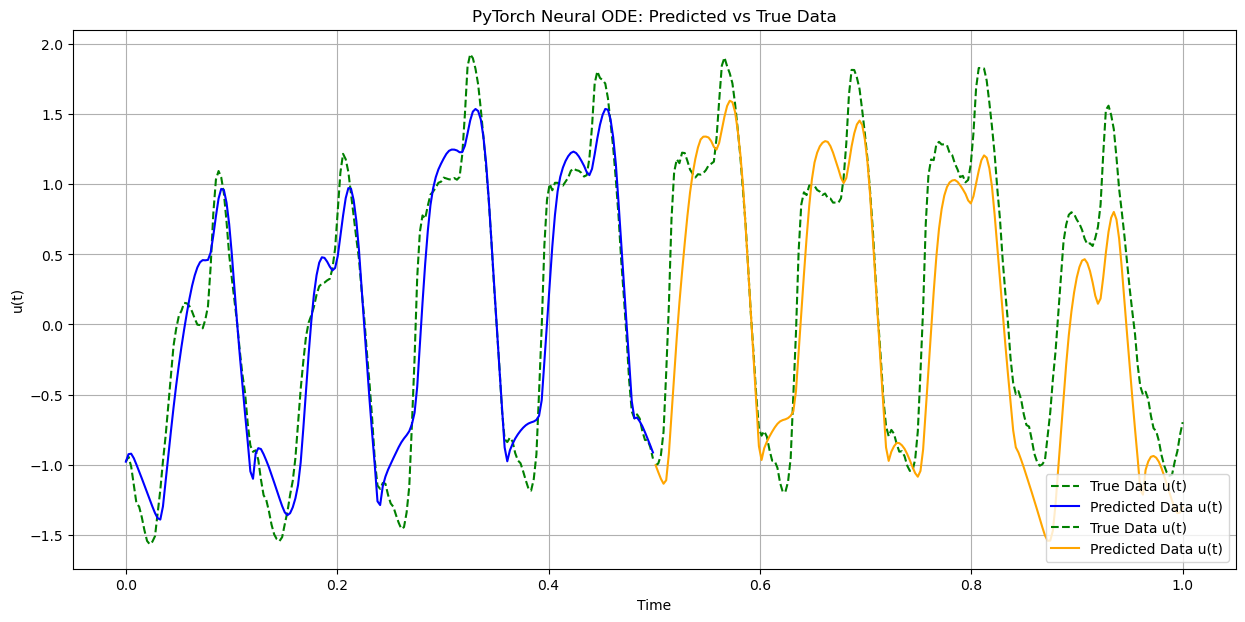

In [ ]:
y_test_pred = y_pred_test.detach().numpy().flatten()
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'g--', label='True Data u(t)')  
plt.plot(ts, y_pred, 'b', label='Predicted Data u(t)') 
plt.plot(ts_test, ys_test, 'g--', label='True Data u(t)') 
plt.plot(ts_test, y_test_pred, 'orange', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.title('PyTorch Neural ODE: Predicted vs True Data')
plt.show()